# Developing and visualising metrics

## Imports

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import json
import random
from scipy.stats import spearmanr
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
import pandas as pd
from scipy.stats import spearmanr


import asyncio
import nest_asyncio
nest_asyncio.apply()

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import pubmetric.network as nw
import pubmetric.pckg_dev as dev
import pubmetric.metrics as met
from style import palette, red_palette15

In [13]:
path_to_data = '../out/out_20240814142510'  
loaded_graph = asyncio.run(nw.create_network(inpath=path_to_data, load_graph=True))

2024-08-25 22:08:53 - Loading graph from ../out/out_20240814142510/graph.pkl.
2024-08-25 22:08:53 - Graph loaded from ../out/out_20240814142510/graph.pkl.
2024-08-25 22:08:53 - Complete data download and graph creation took 0:00:00.006039


# Expert Rated Dataset 

## Load dataset

In [ ]:
# LOAD training data  
with open('../data/train_rated.json', 'r') as json_file:
    train_set = json.load(json_file)

pmid_workflows = [item['pmid_workflow'] for item in train_set]
expert_ratings = [workflow['ratingAvg'] for workflow in train_set]

Test for one

In [17]:
met.complete_average(graph=loaded_graph, workflow=pmid_workflows[0])

724.333

## Running metrics

In [21]:
workflow_average_score = []
complete_average_score = []
citation_scores = []
path_scores = []
random_scores = []

random.seed(42)



for workflow in pmid_workflows:
    workflow_average_score.append(met.workflow_average(graph=loaded_graph, workflow=workflow))
    complete_average_score.append(met.complete_average(graph=loaded_graph, workflow=workflow))
    citation_scores.append(met.median_citations(loaded_graph, workflow))
    random_scores.append(random.randrange(0,6))
    path_scores.append(met.shortest_path(graph=loaded_graph, workflow=workflow))

# Metrics and their names
base_metrics = [workflow_average_score, complete_average_score, path_scores, citation_scores, random_scores]

metric_names = ['Workflow Average Score', 'Complete Average Score', 'Shortest-path Score', 'Citation Scores', 'Random Scores']

half = len(expert_ratings) // 2

correlations = []
for metric in base_metrics:
    full_correlation, full_p_value = spearmanr(expert_ratings, metric)
    
    first_half_correlation, first_half_p_value = spearmanr(expert_ratings[:half], metric[:half])
    second_half_correlation, second_half_p_value = spearmanr(expert_ratings[half:], metric[half:])
    
    # Variation score (difference in correlations between the two halves)
    variation_score = first_half_correlation - second_half_correlation
    
    correlations.append({
        'full': (round(full_correlation, 4), full_p_value),
        'first_half': (round(first_half_correlation, 4), first_half_p_value),
        'second_half': (round(second_half_correlation, 4), second_half_p_value),
        'variation_score': round(variation_score, 4)
    })

for i, corr in enumerate(correlations):
    print(f"Metric: {metric_names[i]}:")
    print(f"  Full data: Correlation = {corr['full'][0]}, p-value = {corr['full'][1]:.1E}")
    print(f"  First half: Correlation = {corr['first_half'][0]}, p-value = {corr['first_half'][1]:.1E}")
    print(f"  Second half: Correlation = {corr['second_half'][0]}, p-value = {corr['second_half'][1]:.1E}")
    print(f"  Variation score: {corr['variation_score']}")




Metric: Workflow Average Score:
  Full data: Correlation = 0.3307, p-value = 8.6E-08
  First half: Correlation = 0.3325, p-value = 1.5E-04
  Second half: Correlation = 0.3306, p-value = 1.7E-04
  Variation score: 0.0019
Metric: Complete Average Score:
  Full data: Correlation = 0.2995, p-value = 1.4E-06
  First half: Correlation = 0.3099, p-value = 4.4E-04
  Second half: Correlation = 0.2894, p-value = 1.1E-03
  Variation score: 0.0205
Metric: Shortest-path Score:
  Full data: Correlation = 0.1527, p-value = 1.6E-02
  First half: Correlation = 0.1873, p-value = 3.6E-02
  Second half: Correlation = 0.1232, p-value = 1.7E-01
  Variation score: 0.0642
Metric: Citation Scores:
  Full data: Correlation = 0.3353, p-value = 5.6E-08
  First half: Correlation = 0.4007, p-value = 3.6E-06
  Second half: Correlation = 0.2747, p-value = 1.9E-03
  Variation score: 0.126
Metric: Random Scores:
  Full data: Correlation = -0.0531, p-value = 4.0E-01
  First half: Correlation = -0.0664, p-value = 4.6E-01

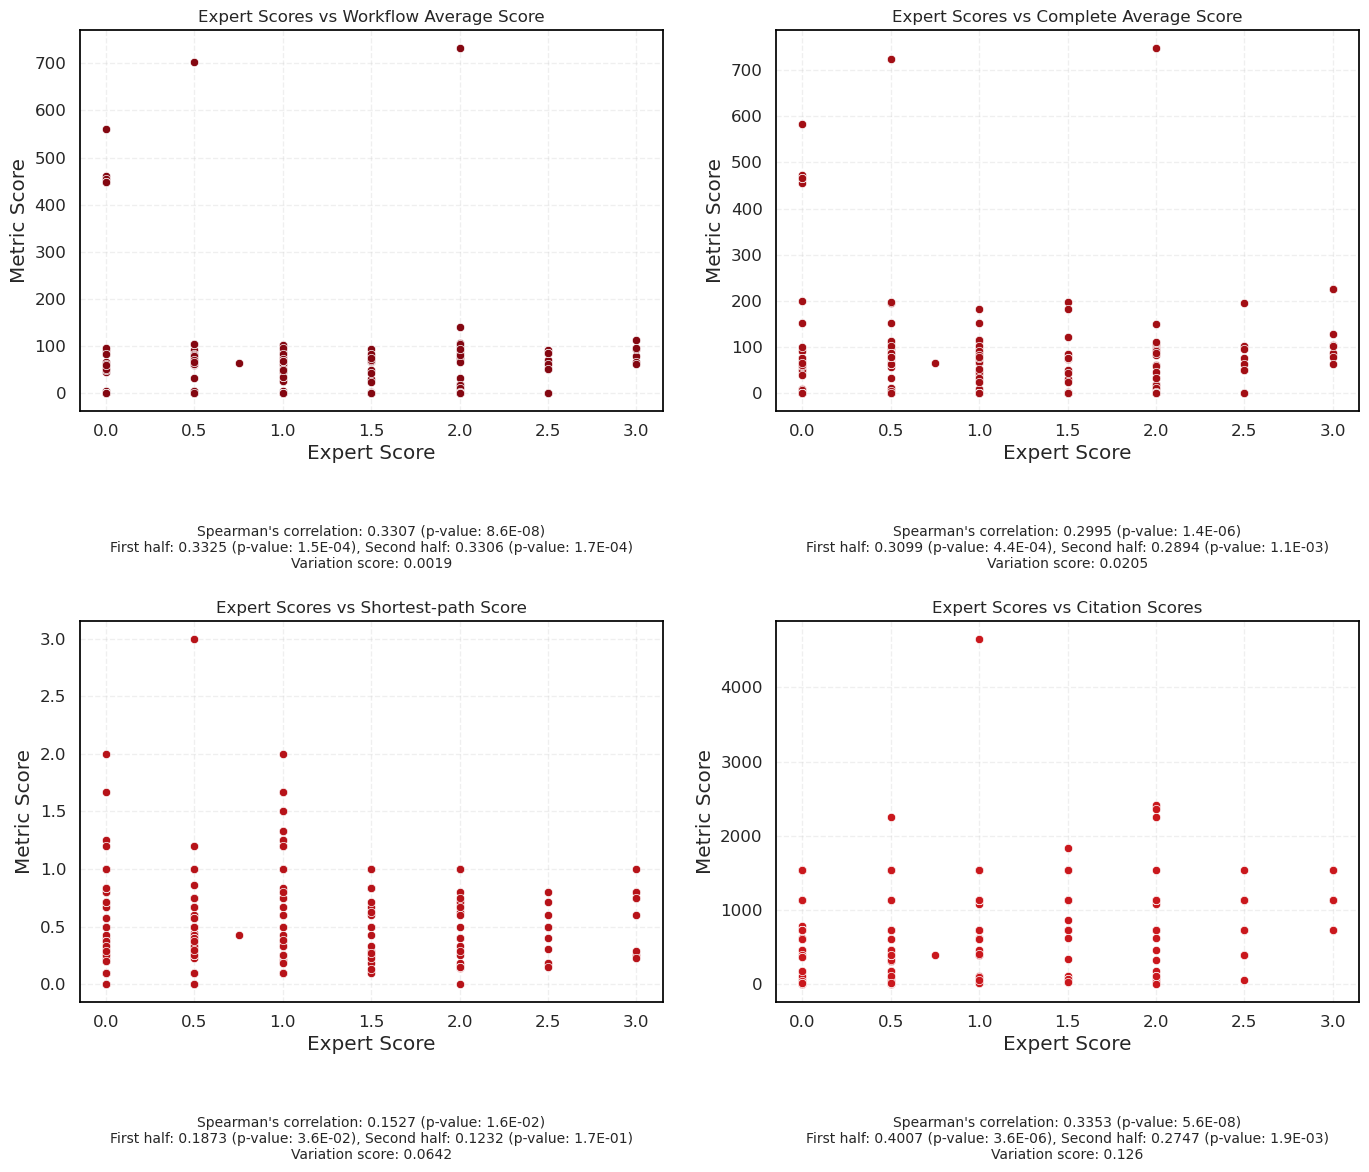

In [22]:
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes1 = axes1.flatten()

for idx, (metric, name, colour, corr) in enumerate(zip(base_metrics[:4], metric_names[:4], red_palette15[:4], correlations[:4])):
    sns.scatterplot(x=expert_ratings, y=metric, color=colour, ax=axes1[idx])
    axes1[idx].set_title(f'Expert Scores vs {name}')
    axes1[idx].set_xlabel('Expert Score')
    axes1[idx].set_ylabel('Metric Score')
    description = (f'Spearman\'s correlation: {corr["full"][0]} (p-value: {corr["full"][1]:.1E})\n'
                   f'First half: {corr["first_half"][0]} (p-value: {corr["first_half"][1]:.1E}), '
                   f'Second half: {corr["second_half"][0]} (p-value: {corr["second_half"][1]:.1E})\n'
                   f'Variation score: {corr["variation_score"]}')
    axes1[idx].text(0.5, -0.3, description, ha='center', va='top', transform=axes1[idx].transAxes, fontsize=10)

for ax in axes1[len(base_metrics[:4]):]:
    fig1.delaxes(ax)

plt.tight_layout()
plt.show()


In [23]:
aggregation_methods = ["sum", "product"]
transforms = [None, "log", "sqrt"]
age_adjustments = [False, True]
degree_adjustments = [False, True]

results = []

for aggregation_method, transform, age_adjustment, degree_adjustment in product(
        aggregation_methods, transforms, age_adjustments, degree_adjustments):

    # Calculate scores for workflow_average and complete_average with current parameters
    workflow_average_scores = []
    complete_average_scores = []
    
    for workflow in pmid_workflows:
        workflow_average_scores.append(
            met.workflow_average(
                graph=loaded_graph, 
                workflow=workflow,
                aggregation_method=aggregation_method,
                transform=transform,
                age_adjustment=age_adjustment,
                degree_adjustment=degree_adjustment
            )
        )
        complete_average_scores.append(
            met.complete_average(
                graph=loaded_graph, 
                workflow=workflow,
                aggregation_method=aggregation_method,
                transform=transform,
                age_adjustment=age_adjustment,
                degree_adjustment=degree_adjustment
            )
        )
    
    # Spearman corr for each metric
    for metric_scores, metric_name in zip(
            [workflow_average_scores, complete_average_scores], 
            ["workflow_average", "complete_average"]):
        
        correlation, p_value = spearmanr(expert_ratings, metric_scores)
        
        results.append({
            'metric': metric_name,
            'scores': metric_scores,
            'aggregation_method': aggregation_method,
            'transform': transform,
            'age_adjustment': age_adjustment,
            'degree_adjustment': degree_adjustment,
            'correlation': correlation,
            'p_value': p_value
        })



#### Scatter - metric scores against expert scores

In [24]:
def normalize_scores(scores): # scale 0 to 3
    min_score = min(scores)
    max_score = max(scores)
    return [(score - min_score) / (max_score - min_score) * 3 if max_score != min_score else 0 for score in scores]


In [25]:
aggregation_methods = ["sum", "product"]
transforms = [None, "log", "sqrt"]
age_adjustments = [False, True]
degree_adjustments = [False, True]

workflow_average_results = []
complete_average_results = []

for aggregation_method, transform, age_adjustment, degree_adjustment in product(
        aggregation_methods, transforms, age_adjustments, degree_adjustments):

    # Calculate scores for workflow_average and complete_average with current parameters
    workflow_average_scores = []
    complete_average_scores = []
    
    for workflow in pmid_workflows:
        workflow_average_scores.append(
            met.workflow_average(
                graph=loaded_graph, 
                workflow=workflow,
                aggregation_method=aggregation_method,
                transform=transform,
                age_adjustment=age_adjustment,
                degree_adjustment=degree_adjustment
            )
        )
        complete_average_scores.append(
            met.complete_average(
                graph=loaded_graph, 
                workflow=workflow,
                aggregation_method=aggregation_method,
                transform=transform,
                age_adjustment=age_adjustment,
                degree_adjustment=degree_adjustment
            )
        )
    
    workflow_correlation, workflow_p_value = spearmanr(expert_ratings, workflow_average_scores)
    complete_correlation, complete_p_value = spearmanr(expert_ratings, complete_average_scores)

    # Normalising to that AIC is not affected by scale 
    normalized_workflow_average_scores = normalize_scores(workflow_average_scores)
    normalized_complete_average_scores = normalize_scores(complete_average_scores)

    # nr parameters
    nr_param = 1 + sum([p is True for p in [age_adjustment, degree_adjustment]])  # 1 for intercept + adjustments
    n_obs = len(expert_ratings)

    # RSS 
    rss_wf = sum((normalized_workflow_average_scores[i] - expert_ratings[i])**2 for i in range(len(expert_ratings)))
    aic_wf = n_obs * np.log(rss_wf / n_obs) + 2 * nr_param

    rss_c = sum((normalized_complete_average_scores[i] - expert_ratings[i])**2 for i in range(len(expert_ratings)))
    aic_c = n_obs * np.log(rss_c / n_obs) + 2 * nr_param


        
    workflow_average_results.append({
        'metric': 'workflow_average',
        'scores': workflow_average_scores,
        'aggregation_method': aggregation_method,
        'transform': transform,
        'age_adjustment': age_adjustment,
        'degree_adjustment': degree_adjustment,
        'correlation': workflow_correlation,
        'p_value': workflow_p_value,
        'AIC': aic_wf
    })
    
    complete_average_results.append({
        'metric': 'complete_average',
        'scores': complete_average_scores,
        'aggregation_method': aggregation_method,
        'transform': transform,
        'age_adjustment': age_adjustment,
        'degree_adjustment': degree_adjustment,
        'correlation': complete_correlation,
        'p_value': complete_p_value,
        'AIC': aic_c
    })




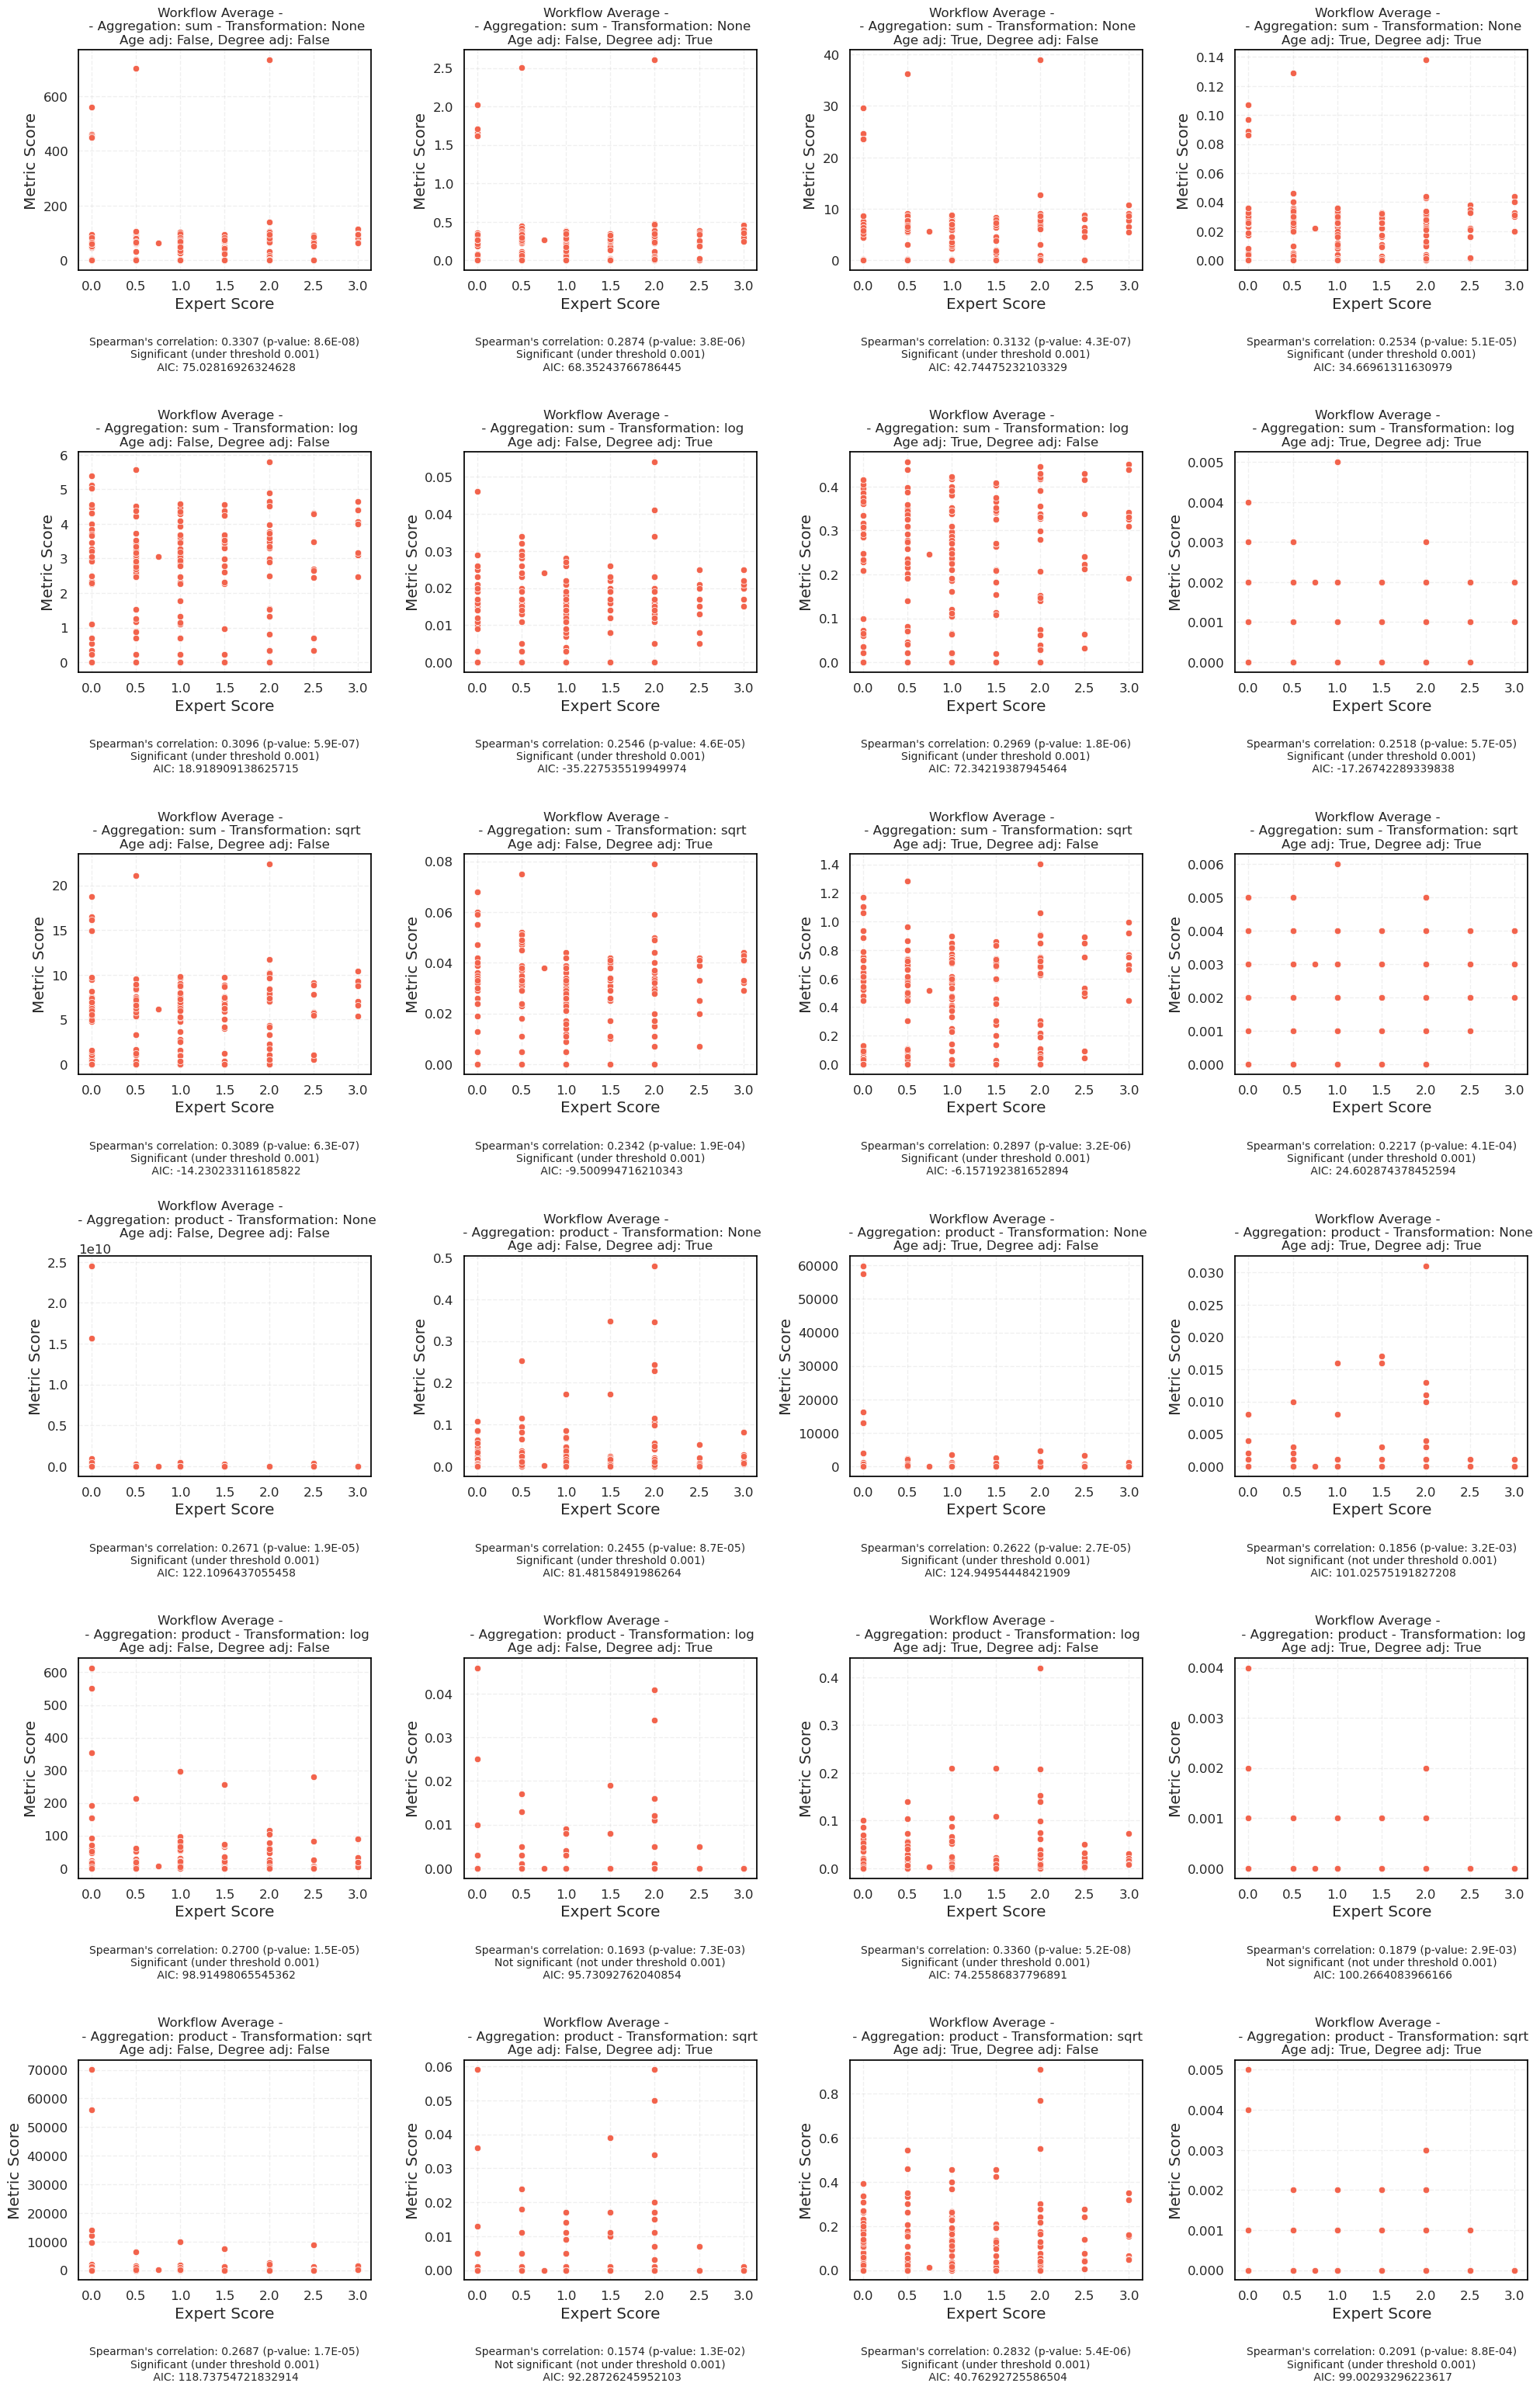

In [27]:
n_rows = 8  
n_cols = 4 # for figs

adjusted_threshold = 0.05 / 50

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 40))
axes = axes.flatten()


for idx, result in enumerate(workflow_average_results):
    metric_scores = result['scores']
    aggregation_method = result['aggregation_method']
    transform = result['transform']
    age_adjustment = result['age_adjustment']
    degree_adjustment = result['degree_adjustment']
    correlation = result['correlation']
    p_value = result['p_value']
    aic = result['AIC']


    sns.scatterplot(x=expert_ratings, y=metric_scores, ax=axes[idx])

    title = (f'Workflow Average -  \n - Aggregation: {aggregation_method} - Transformation: {transform}\n'
             f'Age adj: {age_adjustment}, Degree adj: {degree_adjustment}')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Expert Score')
    axes[idx].set_ylabel('Metric Score')

    if p_value < adjusted_threshold:
        significance_note = f'Significant (under threshold {adjusted_threshold})'
    else:
        significance_note = f'Not significant (not under threshold {adjusted_threshold})'

    description = (f'Spearman\'s correlation: {correlation:.4f} (p-value: {p_value:.1E})\n{significance_note}\n AIC: {aic}') 

    axes[idx].text(0.5, -0.3, description, ha='center', va='top', transform=axes[idx].transAxes, fontsize=10)

for ax in axes[len(workflow_average_results):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


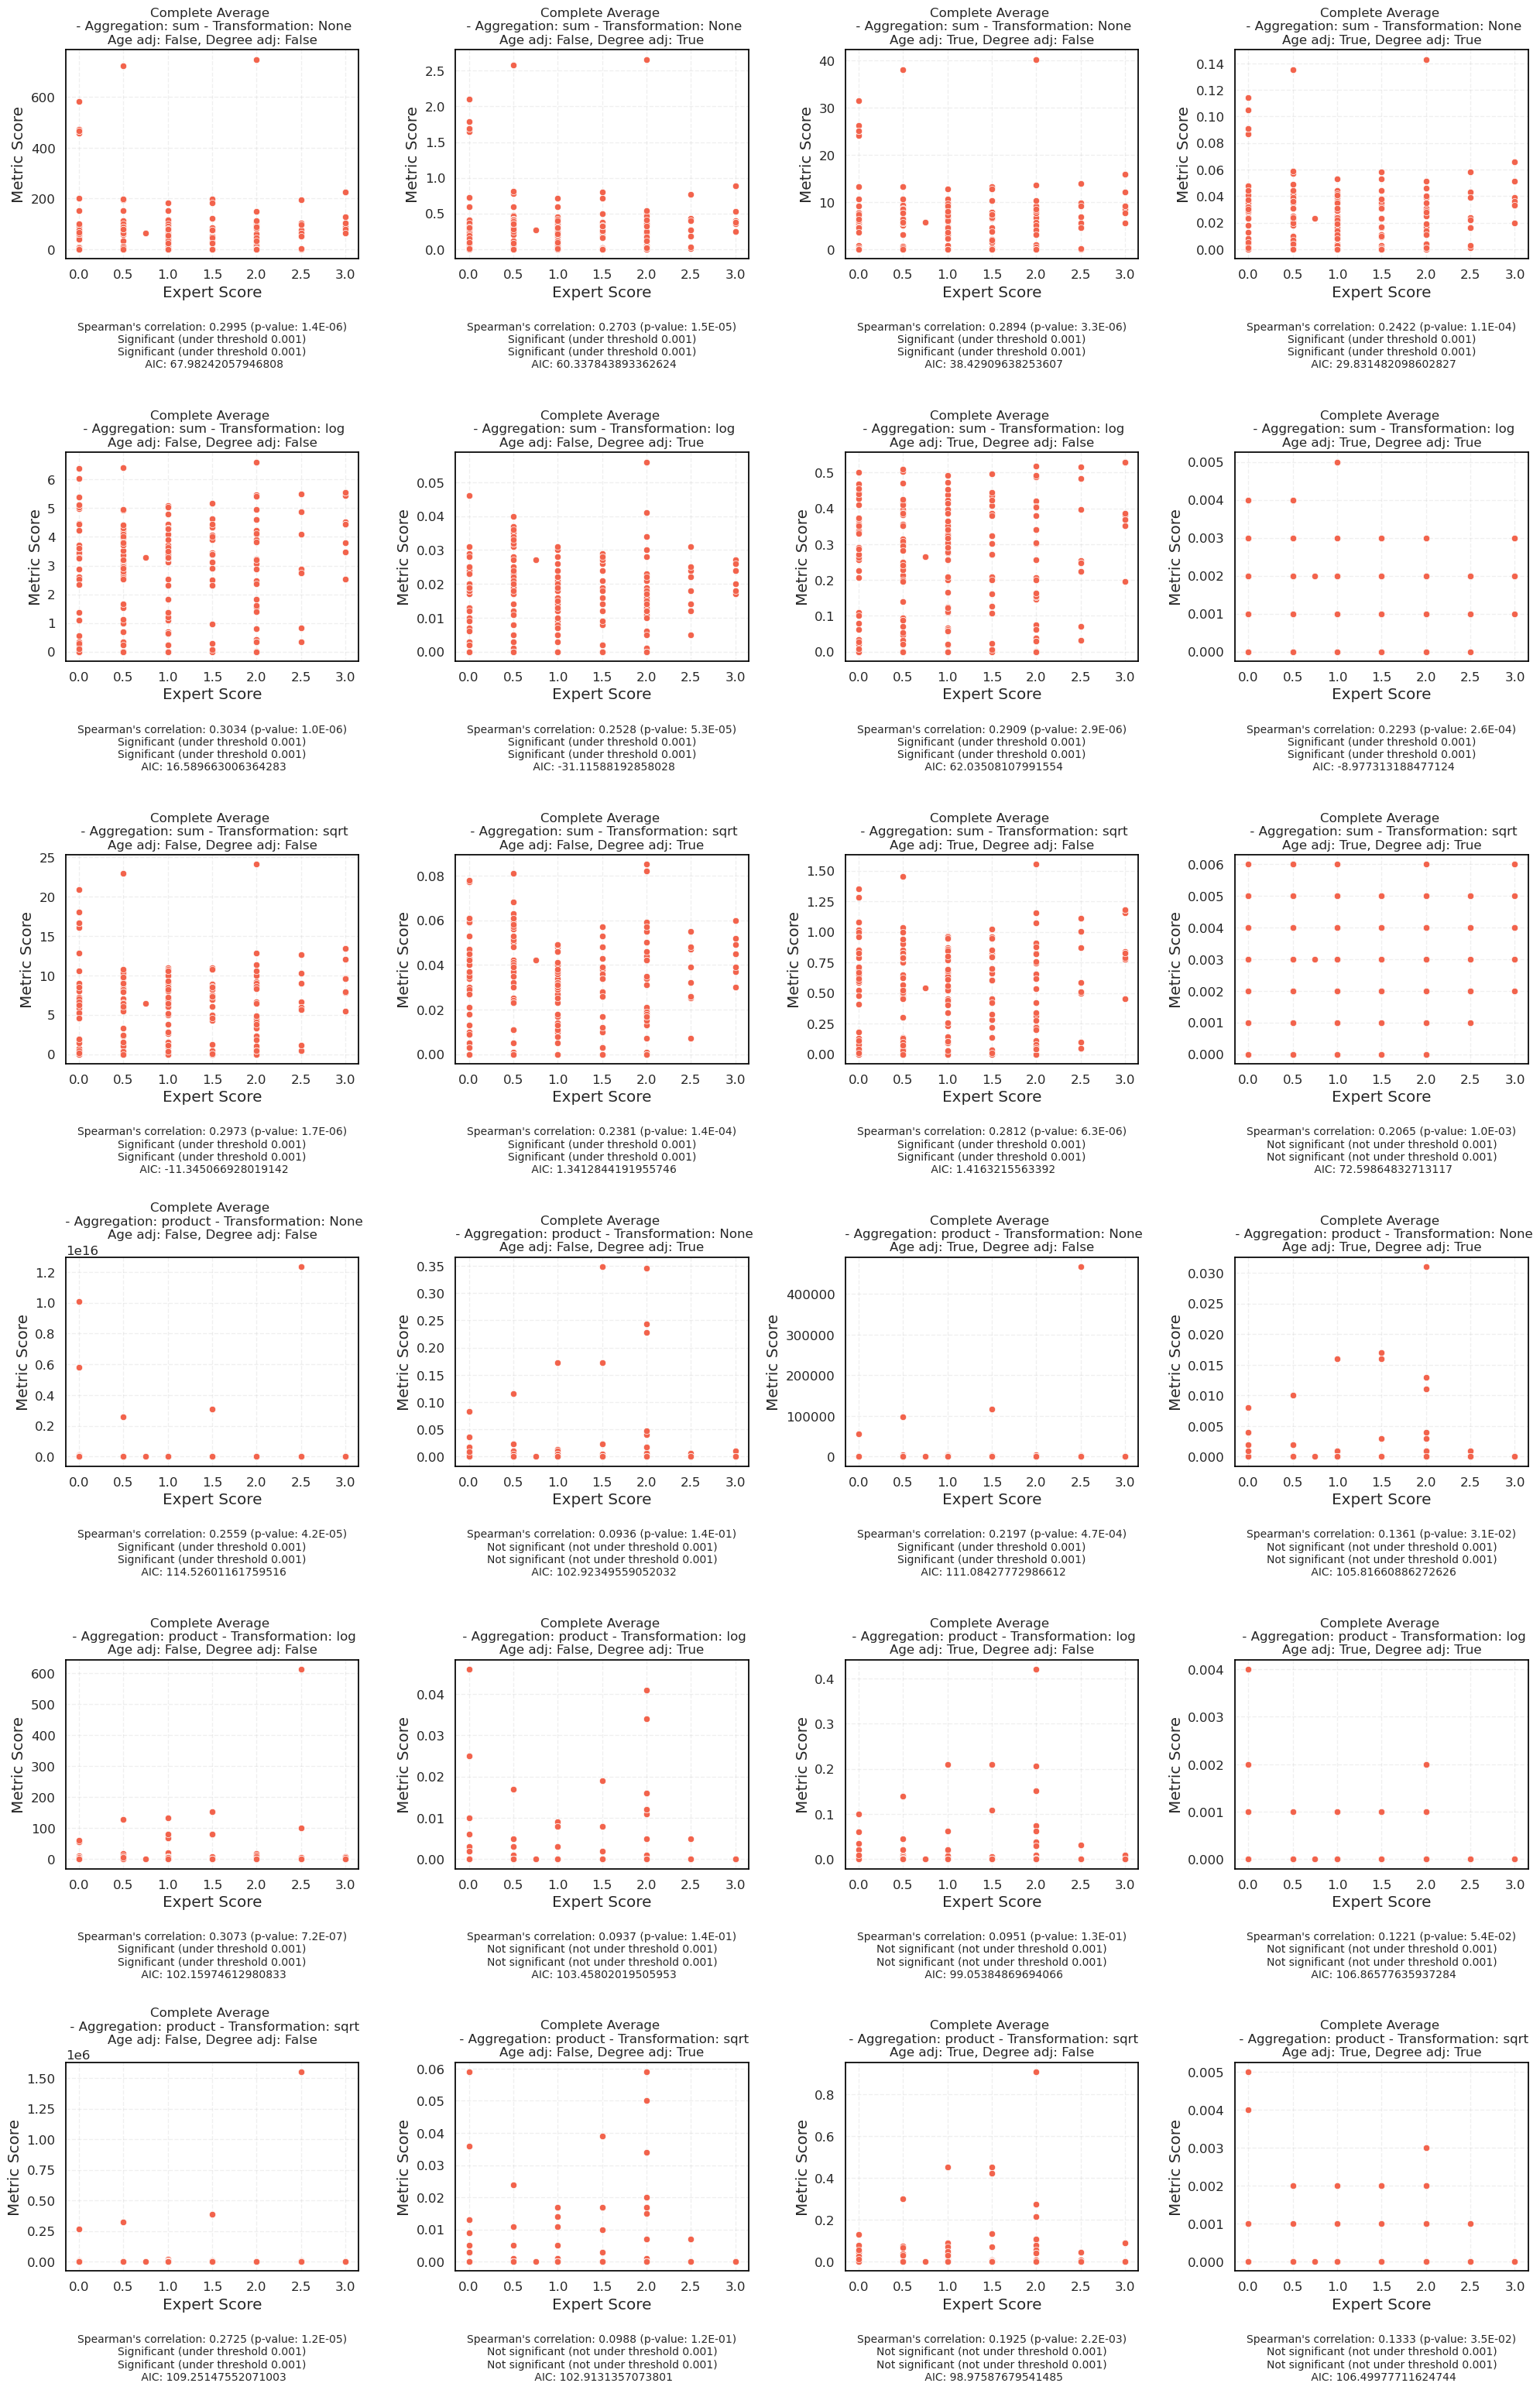

In [28]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 40))
axes = axes.flatten()

for idx, result in enumerate(complete_average_results):
    metric_scores = result['scores']
    aggregation_method = result['aggregation_method']
    transform = result['transform']
    age_adjustment = result['age_adjustment']
    degree_adjustment = result['degree_adjustment']
    correlation = result['correlation']
    p_value = result['p_value']
    aic = result['AIC']

    sns.scatterplot(x=expert_ratings, y=metric_scores, ax=axes[idx])

    title = (f'Complete Average \n - Aggregation: {aggregation_method} - Transformation: {transform}\n'
             f'Age adj: {age_adjustment}, Degree adj: {degree_adjustment}')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Expert Score')
    axes[idx].set_ylabel('Metric Score')
    
    if p_value < adjusted_threshold:
        significance_note = f'Significant (under threshold {adjusted_threshold})'
    else:
        significance_note = f'Not significant (not under threshold {adjusted_threshold})'

    description = (f'Spearman\'s correlation: {correlation:.4f} (p-value: {p_value:.1E})\n{significance_note}\n{significance_note}\n AIC: {aic}')
    axes[idx].text(0.5, -0.3, description, ha='center', va='top', transform=axes[idx].transAxes, fontsize=10)

for ax in axes[len(complete_average_results):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [30]:
top_nr = 20


sorted_workflow_results = sorted(workflow_average_results, key=lambda x: x['AIC'], reverse=False)
print(f"Top {top_nr} parameter combinations with the best AIC values for Workflow Average:")
for result in sorted_workflow_results[:top_nr]:  # Only take top 5 results
    aggregation_method = result['aggregation_method']
    transform = result['transform']
    age_adjustment = result['age_adjustment']
    degree_adjustment = result['degree_adjustment']
    correlation = result['correlation']
    pvalue = result['p_value']
    aic = result['AIC']
    if degree_adjustment== False and age_adjustment== False:
        print(f"Parameters: Aggregation: {aggregation_method}, Transformation: {transform}, Age adj: {age_adjustment}, Degree adj: {degree_adjustment} | Score: {correlation:.4f}, p-value: {pvalue:.2E}, AIC:{aic:.2f}")

sorted_complete_results = sorted(complete_average_results, key=lambda x: x['AIC'], reverse=False)
print(f"Top {top_nr} parameter combinations with the AIC values correlations for Complete Average:")
for result in sorted_complete_results[:top_nr]:  # Only take top 5 results
    aggregation_method = result['aggregation_method']
    transform = result['transform']
    age_adjustment = result['age_adjustment']
    degree_adjustment = result['degree_adjustment']
    correlation = result['correlation']
    pvalue = result['p_value']
    aic = result['AIC']
    print(f"Parameters: Aggregation: {aggregation_method}, Transformation: {transform}, Age adj: {age_adjustment}, Degree adj: {degree_adjustment} | Score: {correlation:.4f}, p-value: {pvalue:.2E}, AIC:{aic:.2f}")


Top 20 parameter combinations with the best AIC values for Workflow Average:
Parameters: Aggregation: sum, Transformation: sqrt, Age adj: False, Degree adj: False | Score: 0.3089, p-value: 6.30E-07, AIC:-14.23
Parameters: Aggregation: sum, Transformation: log, Age adj: False, Degree adj: False | Score: 0.3096, p-value: 5.94E-07, AIC:18.92
Parameters: Aggregation: sum, Transformation: None, Age adj: False, Degree adj: False | Score: 0.3307, p-value: 8.63E-08, AIC:75.03
Parameters: Aggregation: product, Transformation: log, Age adj: False, Degree adj: False | Score: 0.2700, p-value: 1.51E-05, AIC:98.91
Top 20 parameter combinations with the AIC values correlations for Complete Average:
Parameters: Aggregation: sum, Transformation: log, Age adj: False, Degree adj: True | Score: 0.2528, p-value: 5.27E-05, AIC:-31.12
Parameters: Aggregation: sum, Transformation: sqrt, Age adj: False, Degree adj: False | Score: 0.2973, p-value: 1.71E-06, AIC:-11.35
Parameters: Aggregation: sum, Transformatio

In [39]:
top_nr = 4

sorted_workflow_results = sorted(workflow_average_results, key=lambda x: x['correlation'], reverse=True)
print(f"Top {top_nr} parameter combinations with the best correlations for Workflow Average:")
for result in sorted_workflow_results[:top_nr]:  # Only take top 5 results
    aggregation_method = result['aggregation_method']
    transform = result['transform']
    age_adjustment = result['age_adjustment']
    degree_adjustment = result['degree_adjustment']
    correlation = result['correlation']
    pvalue = result['p_value']
    aic = result['AIC']
    print(f"Parameters: Aggregation: {aggregation_method}, Transformation: {transform}, Age adj: {age_adjustment}, Degree adj: {degree_adjustment} | Score: {correlation:.4f}, p-value: {pvalue:.2E}, AIC:{aic:.2f}")

sorted_complete_results = sorted(complete_average_results, key=lambda x: x['correlation'], reverse=True)
print(f"Top {top_nr} parameter combinations with the best correlations for Complete Average:")
for result in sorted_complete_results[:top_nr]:  # Only take top 5 results
    aggregation_method = result['aggregation_method']
    transform = result['transform']
    age_adjustment = result['age_adjustment']
    degree_adjustment = result['degree_adjustment']
    correlation = result['correlation']
    pvalue = result['p_value']
    aic = result['AIC']
    print(f"Parameters: Aggregation: {aggregation_method}, Transformation: {transform}, Age adj: {age_adjustment}, Degree adj: {degree_adjustment} | Score: {correlation:.4f}, p-value: {pvalue:.2E}, AIC:{aic:.2f}")

Top 4 parameter combinations with the best correlations for Workflow Average:
Parameters: Aggregation: product, Transformation: log, Age adj: True, Degree adj: False | Score: 0.3360, p-value: 5.16E-08, AIC:74.26
Parameters: Aggregation: sum, Transformation: None, Age adj: False, Degree adj: False | Score: 0.3307, p-value: 8.63E-08, AIC:75.03
Parameters: Aggregation: sum, Transformation: None, Age adj: True, Degree adj: False | Score: 0.3132, p-value: 4.29E-07, AIC:42.74
Parameters: Aggregation: sum, Transformation: log, Age adj: False, Degree adj: False | Score: 0.3096, p-value: 5.94E-07, AIC:18.92
Top 4 parameter combinations with the best correlations for Complete Average:
Parameters: Aggregation: product, Transformation: log, Age adj: False, Degree adj: False | Score: 0.3073, p-value: 7.23E-07, AIC:102.16
Parameters: Aggregation: sum, Transformation: log, Age adj: False, Degree adj: False | Score: 0.3034, p-value: 1.01E-06, AIC:16.59
Parameters: Aggregation: sum, Transformation: Non

##### Testing on a fake network to illustrate how they work 

In [ ]:
### Testing metrics on example tree
# The network

# Defining the nodes 
tools = ['TA', 'TB', 'TC', 'TD', # connected cluster - included in final graph 
        # Separate cluster - included in final graph 
         'TE', 'TF',
        # Single disconnected cited - not included in final graph 
         'TG', 
        # Single disconnected not cited - not included in final graph 
         'TH']

citations = ['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ']


edges = [

    # Single citations of tools
    ('CA', 'TA'), ('CB', 'TB'), ('CC', 'TC'), ('CD', 'TD'), 
    ('CE', 'TE'), ('CF', 'TF'), ('CG', 'TG'),

    # Citations to multiple tools
    ('CJ', 'TA'), ('CJ', 'TB'),  
    ('CK', 'TA'), ('CK', 'TB'), ('CK', 'TC'),
    ('CL', 'TA'), ('CL', 'TB'), ('CL', 'TC'), ('CL', 'TD'), 
    
    # Duplicate edges
    ('CP', 'TE'), ('CP', 'TE'),

    # Tools citing each other
    ('TB', 'TC'), 

    # Tools citing themselves
    ('TA', 'TA'),

    # Disconnected cluster
    ('CQ', 'TE'), ('CQ', 'TF'), ('CO', 'TE'),
    ('CO', 'TF') 
]

nodes_in_final_network = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF', 'CJ', 'CK', 'CL', 'CO', 'CQ' ]
tools_in_final_network = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF']


testgraph = igraph.Graph.TupleList(edges, directed=True)
incuded_tools = [tool for tool in testgraph.vs['pmid'] if tool in tools] #could do interrsection    
test_coG = nw.create_cocitation_graph(testgraph,incuded_tools)

layout = test_coG.layout("fr")

fig, ax = plt.subplots(figsize=(8, 8))

igraph.plot(
    test_coG,
    target=ax,
    layout=layout,
    vertex_size=0.3,
    vertex_color='skyblue',
    vertex_frame_color='white',
    vertex_label=test_coG.vs['pmid'],
    vertex_label_size=10,
    edge_width=[0.5 + 2 * w for w in test_coG.es['weight']],
    edge_color='gray',
    edge_label=test_coG.es['weight'],
    edge_label_size=10
)

plt.show()

print( testgraph.vs['pmid'])
print( test_coG.vs['pmid'])

print( test_coG.es['weight'])

expected_edge_weights = {('TA', 'TB'): 3, ('TA', 'TC'): 2, ('TA', 'TD'): 1,
('TB', 'TC'): 3, ('TB', 'TD'): 1,
('TC', 'TD'): 1, 
('TE', 'TF'): 2, 
('TE', 'TG'): None, # G not in graph
('TA', 'TE'): 0} # both nodes in graph, but no connection

def test_get_graph_edge_weight():
    for edge, expected_weight in expected_edge_weights.items():
        print(edge,expected_weight)
        weight = get_graph_edge_weight(test_coG, edge)
        print( weight == expected_weight)
test_get_graph_edge_weight()

print(connectivity(test_coG, [('TA', 'TB'), ('TA', 'TC'), ('TA', 'TD')]))

# Random dataset

In [3]:
with open('../data/random_dataset.json') as f:
    random_dataset = json.load(f)

## On workflow average, connectivity and median citations

In [4]:
workflow_average_score = []
connectivity_score = []
citation_scores = []
path_scores = []


for workflows in random_dataset:

    ape_workflow = workflows['APE_workflow']
    retained_degree_random_workflow = workflows['retained_degree_random_workflow']
    completely_random_workflow = workflows['completely_random_workflow']

    workflow_average_score.append((
        met.workflow_average(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.workflow_average(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.workflow_average(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    connectivity_score.append((
        met.complete_average(graph=loaded_graph, workflow=ape_workflow),
        met.complete_average(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.complete_average(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    citation_scores.append((
        met.median_citations(graph=loaded_graph, workflow=ape_workflow),
        met.median_citations(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.median_citations(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    path_scores.append((
        met.shortest_path(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.shortest_path(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.shortest_path(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))


/home/alma/Documents/UU/Thesis/Git/Finalrepo/workflomics-QCmetric/src/pubmetric/metrics.py:167: RuntimeWarning: Couldn't reach some vertices. at src/paths/dijkstra.c:534
  path_length = graph.get_shortest_paths(u_index, to=v_index, weights=graph.es["inverted_weight"], output="epath") or 10


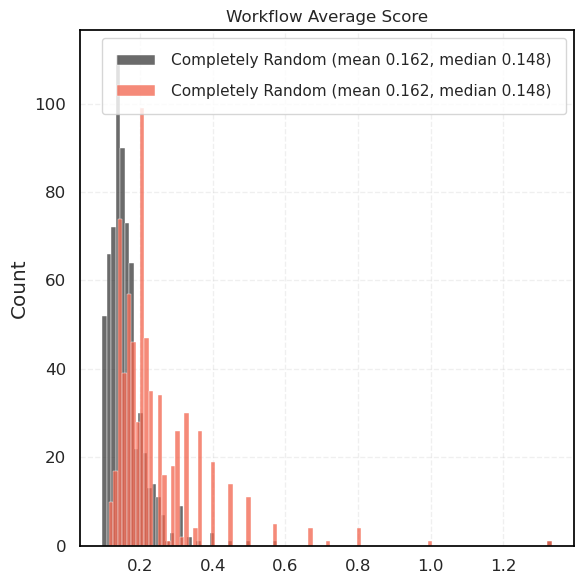

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))

nr_bins = 100
ape_scores, retained_degree_scores, completely_random_scores = zip(*path_scores)

sns.histplot(completely_random_scores, bins=nr_bins, ax=ax, color=palette[1], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')
sns.histplot(ape_scores, bins=nr_bins, ax=ax, color=palette[0], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')

ax.set_title('Workflow Average Score')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


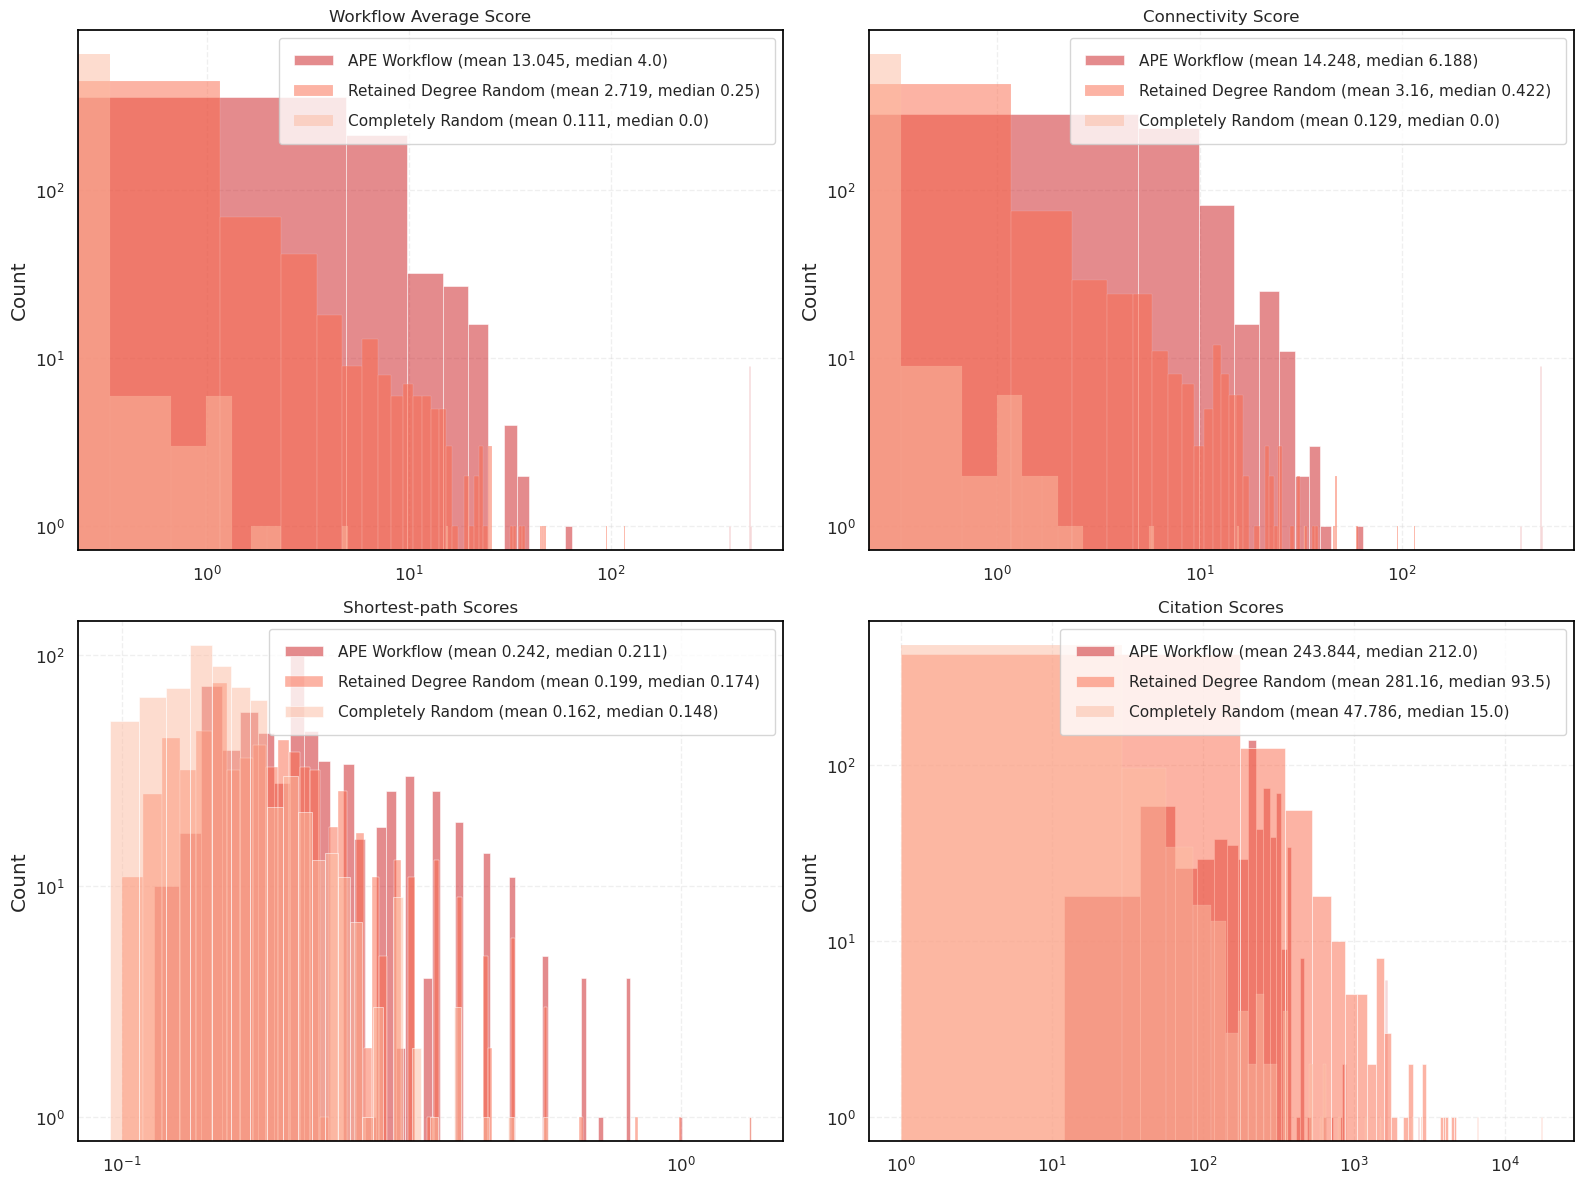

In [10]:
red_palette = sns.color_palette("Reds", n_colors=3).as_hex()[::-1]


metrics = [
    workflow_average_score, connectivity_score, path_scores, citation_scores
]

metric_names = [
    'Workflow Average Score', 'Connectivity Score', 'Shortest-path Scores', 'Citation Scores'
]

fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(16, 12))
axes = axes.flatten()



for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ape_scores, retained_degree_scores, completely_random_scores = zip(*metric)
    
    nr_bins = 100
    sns.histplot(ape_scores, bins=nr_bins,  alpha=0.5, ax=axes[idx], color=palette[0], label=f'APE Workflow (mean {round(np.mean(ape_scores), 3)}, median {round(np.median(ape_scores), 3)})')
    sns.histplot(retained_degree_scores,  alpha=0.5, bins=nr_bins, ax=axes[idx], color=palette[1],  label=f'Retained Degree Random (mean {round(np.mean(retained_degree_scores), 3)}, median {round(np.median(retained_degree_scores), 3)})')
    sns.histplot(completely_random_scores,  alpha=0.5, bins=nr_bins, ax=axes[idx], color=palette[2], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')



    axes[idx].legend(loc='upper right', bbox_to_anchor=(1, 1))
    axes[idx].set_yscale('log')
    axes[idx].set_xscale('log')
    axes[idx].set_title(name)

plt.tight_layout()
plt.show()

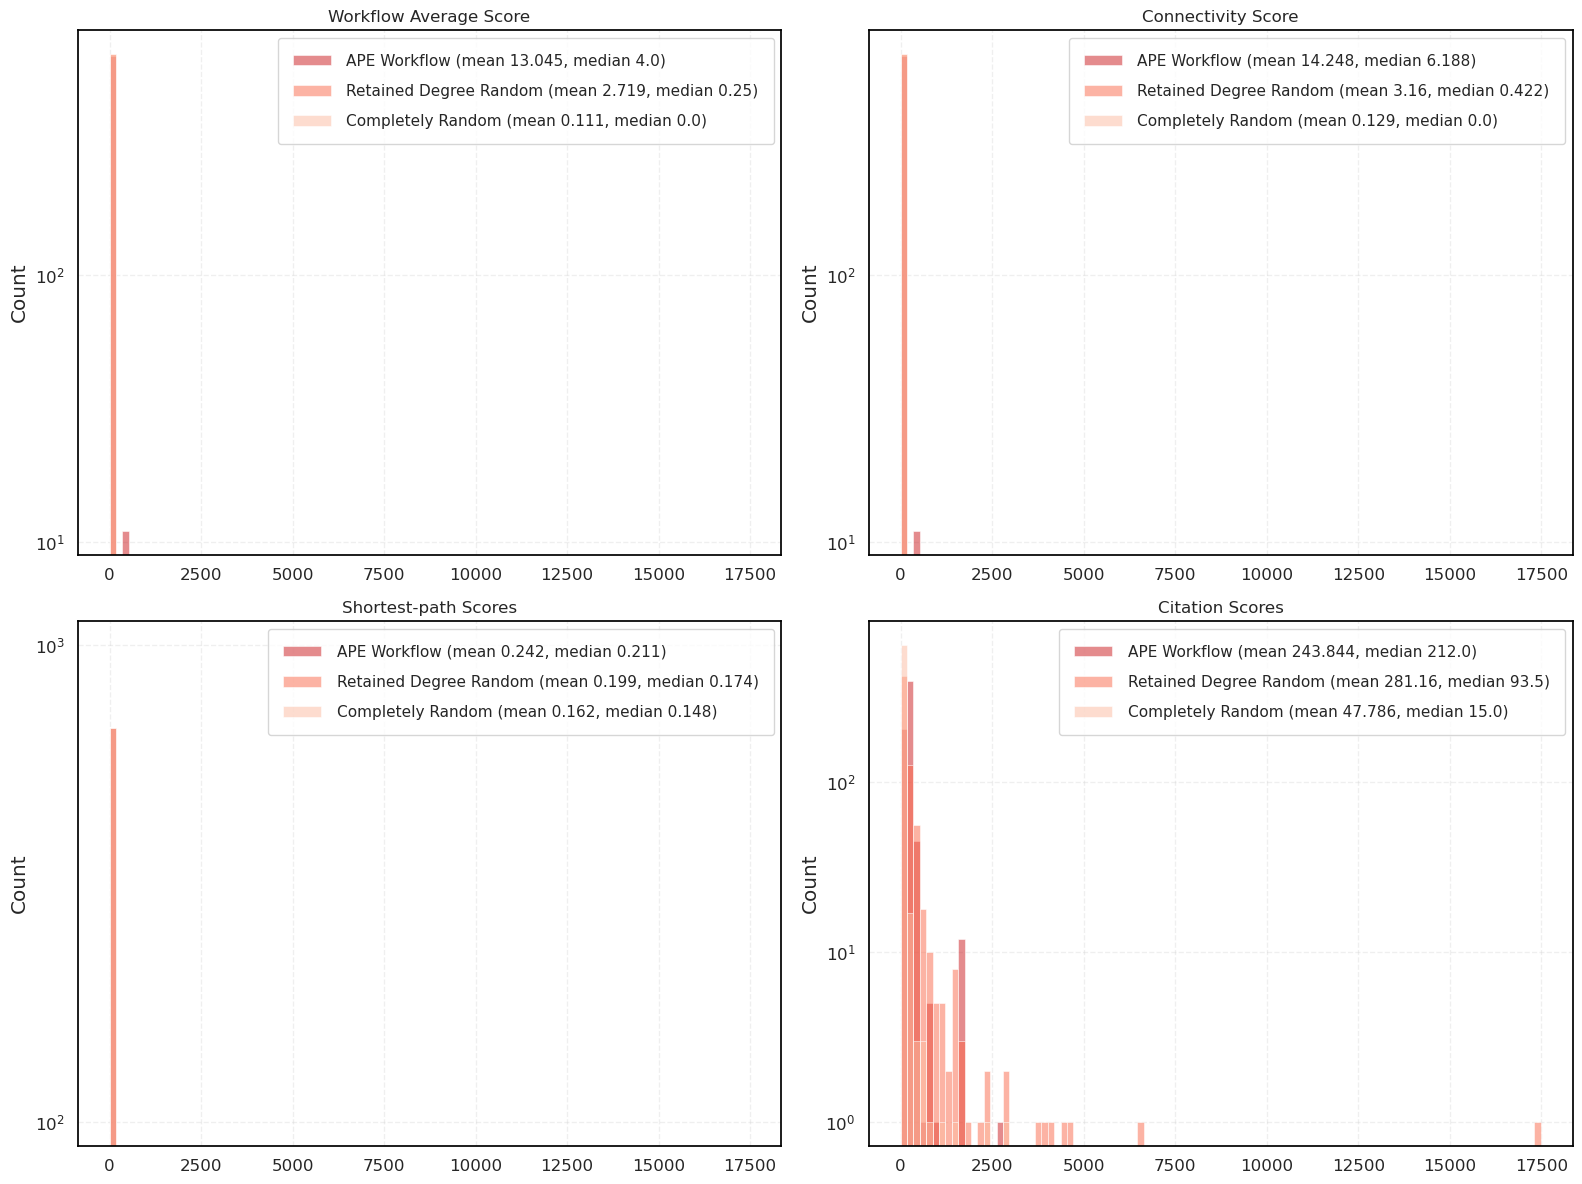

In [9]:
metrics = [
    workflow_average_score, connectivity_score, path_scores, citation_scores
]

metric_names = [
    'Workflow Average Score', 'Connectivity Score', 'Shortest-path Scores', 'Citation Scores'
]

all_scores = []
for metric in metrics:
    ape_scores, retained_degree_scores, completely_random_scores = zip(*metric)
    all_scores.extend(ape_scores)
    all_scores.extend(retained_degree_scores)
    all_scores.extend(completely_random_scores)

min_score = min(all_scores)
max_score = max(all_scores)

nr_bins = 100
bin_edges = np.linspace(min_score, max_score, nr_bins + 1)

fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(16, 12))
axes = axes.flatten()

palette = sns.color_palette("Reds", n_colors=3).as_hex()[::-1]

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ape_scores, retained_degree_scores, completely_random_scores = zip(*metric)
    
    sns.histplot(ape_scores, bins=bin_edges, alpha=0.5, ax=axes[idx], color=palette[0], label=f'APE Workflow (mean {round(np.mean(ape_scores), 3)}, median {round(np.median(ape_scores), 3)})')
    sns.histplot(retained_degree_scores, bins=bin_edges, alpha=0.5, ax=axes[idx], color=palette[1], label=f'Retained Degree Random (mean {round(np.mean(retained_degree_scores), 3)}, median {round(np.median(retained_degree_scores), 3)})')
    sns.histplot(completely_random_scores, bins=bin_edges, alpha=0.5, ax=axes[idx], color=palette[2], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')

    axes[idx].legend(loc='upper right', bbox_to_anchor=(1, 1))
    axes[idx].set_yscale('log')
    axes[idx].set_title(name)

plt.tight_layout()
plt.show()


In [49]:
from scipy.stats import ttest_rel

def get_significance_stats(ape_scores, random_scores):
    t_stat, p_value = ttest_rel(ape_scores, random_scores)
    is_significant = p_value < (0.05/4) and t_stat > 0
    return is_significant, t_stat, p_value

workflow_significance = {
    "workflow_average": {
        "degree_random": get_significance_stats(
            [score[0] for score in workflow_average_score], 
            [score[1] for score in workflow_average_score]
        ),
        "completely_random": get_significance_stats(
            [score[0] for score in workflow_average_score], 
            [score[2] for score in workflow_average_score]
        )
    },
    "connectivity": {
        "degree_random": get_significance_stats(
            [score[0] for score in connectivity_score], 
            [score[1] for score in connectivity_score]
        ),
        "completely_random": get_significance_stats(
            [score[0] for score in connectivity_score], 
            [score[2] for score in connectivity_score]
        )
    },
    "path": {
        "degree_random": get_significance_stats(
            [score[0] for score in path_scores], 
            [score[1] for score in path_scores]
        ),
        "completely_random": get_significance_stats(
            [score[0] for score in path_scores], 
            [score[2] for score in path_scores]
        )
    },
    "citation": {
        "degree_random": get_significance_stats(
            [score[0] for score in citation_scores], 
            [score[1] for score in citation_scores]
        ),
        "completely_random": get_significance_stats(
            [score[0] for score in citation_scores], 
            [score[2] for score in citation_scores]
        )
    }
}

for metric, comparisons in workflow_significance.items():
    print(f"Metric: {metric}")
    for comparison_type, (is_significant, t_stat, p_value) in comparisons.items():
        status = "Significantly Higher" if is_significant else "Not Significantly Higher"
        print(f"  - APE vs {comparison_type.replace('_', ' ').title()}: {status}")
        print(f"    t-statistic: {t_stat:.2f}, p-value: {p_value:.2e}")
    print()


Metric: workflow_average
  - APE vs Degree Random: Significantly Higher
    t-statistic: 4.46, p-value: 9.46e-06
  - APE vs Completely Random: Significantly Higher
    t-statistic: 5.55, p-value: 4.19e-08

Metric: connectivity
  - APE vs Degree Random: Significantly Higher
    t-statistic: 4.76, p-value: 2.32e-06
  - APE vs Completely Random: Significantly Higher
    t-statistic: 6.02, p-value: 2.84e-09

Metric: path
  - APE vs Degree Random: Significantly Higher
    t-statistic: 14.05, p-value: 1.79e-39
  - APE vs Completely Random: Significantly Higher
    t-statistic: 18.36, p-value: 2.80e-61

Metric: citation
  - APE vs Degree Random: Not Significantly Higher
    t-statistic: -1.10, p-value: 2.73e-01
  - APE vs Completely Random: Significantly Higher
    t-statistic: 17.16, p-value: 5.58e-55



## On all

In [29]:
workflow_average_score = []
degree_workflow_average_score = []
log_worfklow_average_score = []
workflow_product_score = []
log_workflow_product_score = []
connectivity_score = []
workflow_weighted_connectivity_score = []
age_workflow_average_score = []
age_connectivity_score = []
min_connectivity_score = []
citations_connectivity_score = []
citation_scores = []

for workflows in random_dataset:

    ape_workflow = workflows['APE_workflow']
    retained_degree_random_workflow = workflows['retained_degree_random_workflow']
    completely_random_workflow = workflows['completely_random_workflow']

    workflow_average_score.append((
        met.workflow_average_sum(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.workflow_average_sum(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.workflow_average_sum(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    degree_workflow_average_score.append((
        met.degree_workflow_average_sum(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.degree_workflow_average_sum(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.degree_workflow_average_sum(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    log_worfklow_average_score.append((
        met.log_workflow_edge_product(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.log_workflow_edge_product(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.log_workflow_edge_product(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    workflow_product_score.append((
        met.workflow_edge_product(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.workflow_edge_product(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.workflow_edge_product(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    log_workflow_product_score.append((
        met.log_workflow_edge_product(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.log_workflow_edge_product(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.log_workflow_edge_product(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    age_workflow_average_score.append((
        met.age_workflow_average_sum(graph=loaded_graph, workflow=ape_workflow['pmid_edges']),
        met.age_workflow_average_sum(graph=loaded_graph, workflow=retained_degree_random_workflow['pmid_edges']),
        met.age_workflow_average_sum(graph=loaded_graph, workflow=completely_random_workflow['pmid_edges'])
    ))

    connectivity_score.append((
        met.connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    workflow_weighted_connectivity_score.append((
        met.workflow_weighted_connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.workflow_weighted_connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.workflow_weighted_connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    age_connectivity_score.append((
        met.age_connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.age_connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.age_connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    min_connectivity_score.append((
        met.min_connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.min_connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.min_connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    citations_connectivity_score.append((
        met.citation_connectivity(graph=loaded_graph, workflow=ape_workflow),
        met.citation_connectivity(graph=loaded_graph, workflow=retained_degree_random_workflow),
        met.citation_connectivity(graph=loaded_graph, workflow=completely_random_workflow)
    ))

    citation_scores.append((
        met.median_citations(loaded_graph, ape_workflow),
        met.median_citations(loaded_graph, retained_degree_random_workflow),
        met.median_citations(loaded_graph, completely_random_workflow)
    ))


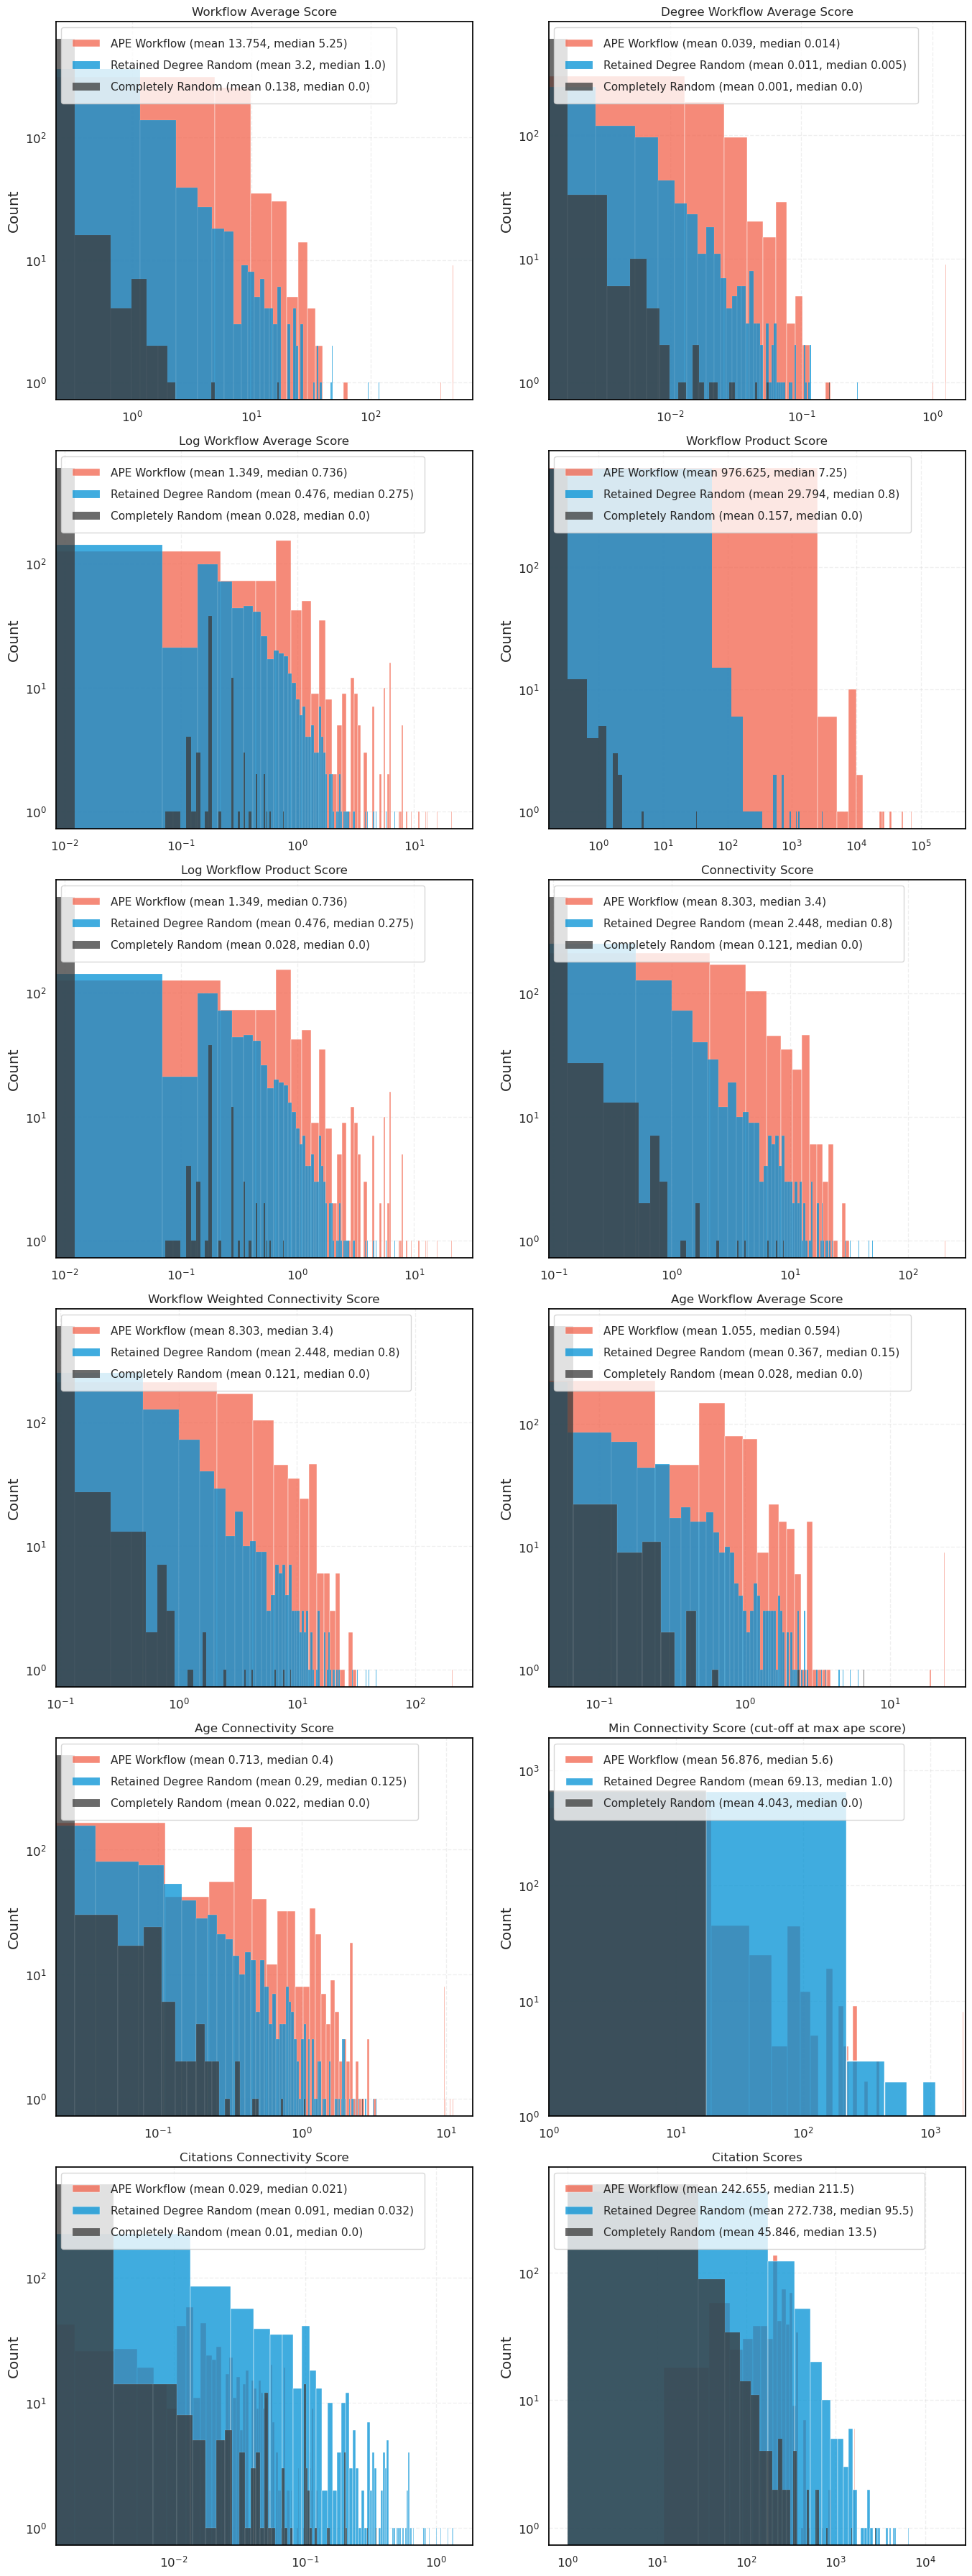

In [30]:

red_palette = sns.color_palette("Reds", n_colors=3).as_hex()[::-1]


metrics = [
    workflow_average_score, degree_workflow_average_score, log_worfklow_average_score, 
    workflow_product_score, log_workflow_product_score, connectivity_score, 
    workflow_weighted_connectivity_score, age_workflow_average_score, age_connectivity_score, 
    min_connectivity_score, citations_connectivity_score, citation_scores
]

metric_names = [
    'Workflow Average Score', 'Degree Workflow Average Score', 'Log Workflow Average Score',
    'Workflow Product Score', 'Log Workflow Product Score', 'Connectivity Score', 
    'Workflow Weighted Connectivity Score', 'Age Workflow Average Score', 'Age Connectivity Score',
    'Min Connectivity Score', 'Citations Connectivity Score', 'Citation Scores'
]

fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(14, 36))
axes = axes.flatten()



for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ape_scores, retained_degree_scores, completely_random_scores = zip(*metric)
    
    nr_bins = 100
    sns.histplot(ape_scores, bins=nr_bins, ax=axes[idx], color=palette[0], label=f'APE Workflow (mean {round(np.mean(ape_scores), 3)}, median {round(np.median(ape_scores), 3)})')
    axes[idx].set_title(name)
    if name ==  'Min Connectivity Score':
        lim_x = (1, max(ape_scores))
        lim_y = (1, max(ape_scores))
        axes[idx].set_xlim(lim_x)
        axes[idx].set_ylim(lim_y)
        axes[idx].set_title(name + " (cut-off at max ape score)") # otherwise it did not show the distribution 
        

    sns.histplot(retained_degree_scores, bins=nr_bins, ax=axes[idx], color=palette[4],  label=f'Retained Degree Random (mean {round(np.mean(retained_degree_scores), 3)}, median {round(np.median(retained_degree_scores), 3)})')
    sns.histplot(completely_random_scores, bins=nr_bins, ax=axes[idx], color=palette[1], label=f'Completely Random (mean {round(np.mean(completely_random_scores), 3)}, median {round(np.median(completely_random_scores), 3)})')




    axes[idx].set_yscale('log')
    axes[idx].set_xscale('log')
    # axes[idx].set_title(name)
    axes[idx].legend()

plt.tight_layout()
plt.show()